# machine learning project
## Apartment rental price prediction based on machine learning and feature engineering

### Presented by: Bnaya Unger

In [2104]:
id= '318201571'

In [ ]:
#!pip install ppscore
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import time 
import re
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce 
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import pickle
import math
from IPython.display import display
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2164]:
data = pd.read_csv("C:\\Users\\user\\Desktop\\תואר הנדסה תעשיה וניהול\\שנה ג'\\סמסטר ב\\למידת מכונה\\train.csv")

In [2181]:
data.isna().sum()

property_type             2
neighborhood              4
address                  30
room_num                  0
floor                     5
area                      0
garden_area             126
days_to_enter           180
num_of_payments           7
monthly_arnona          160
building_tax            132
total_floors             45
description               5
has_parking               0
has_storage               0
elevator                  0
ac                        0
handicap                  0
has_bars                  0
has_safe_room             0
has_balcony               0
is_furnished              0
is_renovated              0
price                     2
num_of_images             1
distance_from_center     19
dtype: int64

<div dir="rtl">

## הסבר על הפונקציה:

1. יצרתי מילון `params` שמכיל את כל הפרמטרים מה־`train`, ובסוף הפונקציה אני שומר אותו כקובץ `pkl` כדי שאוכל להשתמש בו ב־`test`.  
2. בעמודות הבוליאניות (`has_parking`, `has_storage`, `elevator`, `ac`, `handicap`, `has_bars`, `has_safe_room`, `has_balcony`, `is_furnished`, `is_renovated`) השלמתי ערכים חסרים לפי הערך השכיח מה־`train`.  
3. הסרתי שורות שחסרים בהן ערכים בעמודות `price` או `neighborhood`, כיוון שאלה כנראה שורות לא תקינות או לא שימושיות. בנוסף, סיננתי ערכים קיצוניים ב־`price` וב־`area`.  
4. יצרתי פונקציות שמנסות להשלים את העמודות `property_type`, `floor` ו־`area` לפי טקסט עמודת `description`.  
5. יצרתי פונקציה שמשלימה את `room_num` על בסיס `area`, או לפי חיפוש בטקסט.  
6. איחדתי ערכים דומים בעמודת `property_type` והשלמתי ערכים חסרים לפי מילות מפתח בטקסט.  
7. ניקיתי את עמודות `floor` ו־`total_floors` מערכים שגויים, למשל כאלה שמכילים את שניהם יחד או ערכים חריגים.  
8. הסבתי ערכים ב־`distance_from_center` ליחידות אחידות, והשלמתי ערכים חסרים לפי `address`, `neighborhood` או ממוצע כללי.  
9. בעמודת `building_tax`, מילאתי ערכים חסרים לפי ממוצע של `neighborhood` ו־`elevator`, ואם לא נמצא – לפי ממוצע עבור `elevator` בלבד.  
10. ניקיתי את עמודת `address` ממספרים ואיחדתי שמות רחובות דומים כדי למנוע ריבוי ייצוגים.  
11. השלמתי ערכים חסרים ב־`floor` ו־`total_floors` לפי ממוצע עבור `address`, ואם אין – לפי `neighborhood`, ואם עדיין חסר – הנחתי שסך הקומות שווה לקומה.  
12. בעמודת `distance_from_center`, אם יש ערכים חסרים – הם מולאו לפי ממוצע של `address`, אחר כך לפי `neighborhood`, ואם לא – לפי ממוצע כללי.  
13. אם בעמודת `neighborhood` חסר ערך, השלמתי את השכונה הקרובה ביותר לפי ערך `distance_from_center`.  
14. השלמתי ערכים חסרים בעמודת `monthly_arnona` לפי טווחי `area`.  
15. הסרתי עמודות לא שימושיות לחיזוי כמו `description`, `address`, `garden_area`, `num_of_images`, `num_of_payments`, `days_to_enter`, והוספתי את העמודה החדשה `room_per_area`.  
16. יישמתי קידוד One-Hot על `property_type`, קידוד Target על `neighborhood`, ו־`StandardScaler` על העמודות המספריות.  

</div>


In [2183]:
def preper_data(df, train_test):
    df=df.copy()
#1
    params={}
    if train_test== "train":
#2
        boolean_cols = ['has_parking', 'has_storage', 'elevator', 'ac', 'handicap',
                'has_bars', 'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated']
        boolean_modes = df[boolean_cols].mode().iloc[0] 
        params['boolean_modes'] = boolean_modes
#3
        df = df.dropna(subset=['neighborhood', 'price'])
        df = df[(df["price"] > 1000) & (df["price"] <= 45000)]
        df = df[df['area']>10]
    if train_test == 'test':
        params = joblib.load("all_params.pkl")
        boolean_modes = params['boolean_modes']
        df[boolean_modes.index] = df[boolean_modes.index].fillna(boolean_modes)
    df["address"] = df["address"].replace(["", "nan", None, np.nan], "חסר")    
# 4
    def extract_property_type(text):
        if not isinstance(text, str): return None
        types = ["דופלס","דירה", "פנטהאוז", "דירת גן", "דו משפחתי", "קוטג", "וילה","מגרש"]
        for t in types:
            if t in text:
                return t
        return None
    type_nan = df['property_type'].isna()
    df.loc[type_nan, 'property_type'] = df.loc[type_nan, 'description'].apply(extract_property_type)

    def extract_floor(text):
        if not isinstance(text, str): return None
        match = re.search(r"קומ[ה|ת] ?(\d+)", text)
        return int(match.group(1)) if match else None
    floor_nan = df['floor'].isna()
    df.loc[floor_nan, 'floor'] = df.loc[floor_nan, 'description'].apply(extract_floor)

    def extract_area(row, area_means_by_room,overall_area_mean):
        original_area = row['area']
        description = row['description']
        room_num = row['room_num']
        if isinstance(description, str):
            match = re.search(r"(\d{2,4})\s*(?:מ\"?ר|מר|מטר(?:ים)?)", description)
            if match:
                new_area = int(match.group(1))
                return new_area

        if pd.notna(room_num) and room_num in area_means_by_room:
            filled = area_means_by_room[room_num]
            return filled
        return overall_area_mean
    if train_test == 'train':
        area_means_by_room = df.groupby('room_num')['area'].mean().round()
        overall_area_mean = round(df['area'].mean())
        params['area_means_by_room'] = area_means_by_room
        params['overall_area_mean'] = overall_area_mean
    if train_test == 'test':
        area_means_by_room = params['area_means_by_room']
        overall_area_mean = params['overall_area_mean']
    area_condition = df['area'].isna() | (df['area'] < 20) | (df['area'] > 300)
    df.loc[area_condition, 'area'] = df.loc[area_condition].apply(
        lambda row: extract_area(row, area_means_by_room,overall_area_mean),axis=1)
#5
    def fill_missing_room_num(df, q=4, labels=['קטן', 'בינוני', 'גדול', 'ענק'], mode='train'):
        df['area'] = pd.to_numeric(df['area'], errors='coerce')

        if mode == 'train':
            area_ranges = pd.qcut(df['area'], q=q, labels=labels, duplicates='drop')
            df['area_range'] = area_ranges
            avg_by_range = df[df['room_num'].notna() & (df['room_num'] > 0)].groupby('area_range')['room_num'].mean()
            params['avg_by_range']=avg_by_range
        else:
            avg_by_range = params['avg_by_range']
            df['area_range'] = pd.qcut(df['area'], q=q, labels=labels, duplicates='drop')

        def fill_room(row):
            if pd.isna(row['room_num']) or row['room_num'] == 0:
                match = re.search(r'(\d+(\.\d+)?)\s*חדר', str(row['description']))
                if match:
                    return max(1, math.ceil(float(match.group(1))))
                try:
                    avg = avg_by_range.loc[row['area_range']]
                    return max(1, round(avg))
                except:
                    return row['room_num']  
            return row['room_num']
        df['room_num'] = df.apply(fill_room, axis=1)
        df.drop(columns=['area_range'], inplace=True)
        return df


    if train_test == 'train':
        df = fill_missing_room_num(df, mode='train')
    if train_test == 'test':
        df = fill_missing_room_num(df, mode='test')
#6
    def simplify_property_type(x):
        replacements = {
            "קוטג'": "קוטג'",
            "דירת גן": "דירת גן",
            "דירה": "דירה",
            "פנטהאוז": "פנטהאוז",
            "מגרש": "מגרש",
            "דופלקס": "דופלקס"}
        if isinstance(x, str):
            for key, value in replacements.items():
                if key in x:
                    return value
        return None
    df["property_type"] = df["property_type"].apply(simplify_property_type)
    
    def fill_property_type(df, train_test):
        keywords = {
            'דירה': ["דירת",'דירה', "סטודיו"],
            'דירת גן': ['דירת גן'],
            'קוטג\'פרטי': ['בית פרטי', 'קוטג'],
            'פנטהאוז': ['פנטהאוז', 'גג'],
            'דופלקס': ['דופלקס', 'דו'],
            'מגרש': ['מגרש']}
        valid_types = ['דירה', 'דירת גן', 'קוטג\'פרטי', 'פנטהאוז', 'דופלקס', 'מגרש']
        def detect_type(row):
            if row['property_type'] in valid_types:
                return row['property_type']
            description = str(row['description']).lower()
            for property_type, words in keywords.items():
                for word in words:
                    if word in description:
                        return property_type
            return None  
        df['property_type'] = df.apply(detect_type, axis=1)
        if train_test == "train":
            df = df[df['property_type'].isin(valid_types)]
        else:
            df.loc[~df['property_type'].isin(valid_types), 'property_type'] = 'unknown'
        return df
    df = fill_property_type(df,train_test)
    df["address"].replace(["", "nan", None,np.nan], "חסר", inplace=True)
#7
    def clean_floor_info(df):
        def process_floor_row(row):
            floor_val = str(row['floor']).strip()
            total_floor_val = row.get('total_floors', np.nan)
            description = str(row.get('description', ''))

            clean_floor = np.nan
            clean_total_floor = total_floor_val

            if 'קרקע' in floor_val and 'מתוך' in floor_val:
                match_ground = re.search(r'קרקע\s*מתוך\s*(\d+)', floor_val)
                if match_ground and match_ground.group(1).isdigit():
                    clean_floor = 1
                    clean_total_floor = int(match_ground.group(1))
                else:
                    clean_floor = 1
                    clean_total_floor = 1
            elif 'מתוך' in floor_val:
                match = re.search(r'(\d+)\s*מתוך\s*(\d+)', floor_val)
                if match:
                    clean_floor = int(match.group(1))
                    clean_total_floor = int(match.group(2))

            elif floor_val.isdigit():
                clean_floor = int(floor_val)

            if pd.isna(clean_floor) and 'קומה' in description:
                match_desc = re.search(r'קומה\s*(\d+)', description)
                if match_desc:
                    clean_floor = int(match_desc.group(1))

            if (pd.notna(clean_floor) and int(clean_floor) >= 10
                and (pd.isna(clean_total_floor) 
                     or clean_floor > clean_total_floor)):
                floor_str = str(int(clean_floor))
                length = len(floor_str)

                if length == 4:
                    clean_floor = int(floor_str[:2])
                    clean_total_floor = int(floor_str[2:])
                elif length == 3:
                    clean_floor = int(floor_str[0])
                    clean_total_floor = int(floor_str[1:])
                elif length == 2:
                    clean_floor = int(floor_str[0])
                    clean_total_floor = int(floor_str[1])

            return pd.Series([clean_floor, clean_total_floor])

        df[['floor', 'total_floors']] = df.apply(process_floor_row, axis=1)
        return df
    df = clean_floor_info(df)
#8
    df["distance_from_center"] = df["distance_from_center"].apply(lambda x: x if x < 100 else x / 1000)
    if train_test == 'train':
        df.loc[df["distance_from_center"] > 20, "distance_from_center"] = np.nan

    df["garden_area"] = df["garden_area"].fillna(0)
    df['num_of_images'] = df['num_of_images'].fillna(0)
    df['description'] = df['description'].fillna("חסר תיאור")
#9   
    if train_test== 'train':
        group_means = df.groupby(["neighborhood",'elevator'])["building_tax"].mean()
        overall_mean = df.groupby('elevator')["building_tax"].mean()
        params['group_means']=group_means
        params['overall_mean']=overall_mean
    if train_test== 'test':
        group_means = params['group_means']
        overall_mean = params['overall_mean']
    df = df.merge(group_means, on=["neighborhood", "elevator"], how='left', suffixes=('', '_group_mean'))
    df["building_tax"] = df["building_tax"].fillna(df["building_tax_group_mean"])
    df["building_tax"] = df["building_tax"].fillna(df["elevator"].map(overall_mean))
    df.loc[df['building_tax'] > 8000, 'building_tax'] /= 10
    df.drop(columns="building_tax_group_mean", inplace=True)
#10
    def clean_address_column(df):
        def remove_numbers(address):
            if isinstance(address, str):
                return ' '.join([word for word in address.split() if not word.isdigit()])
            return address

        df['address'] = df['address'].apply(remove_numbers)
        return df
    df = clean_address_column(df)
    def unify_street_names(df, threshold=80):
        df = df.copy()
        df['address_clean'] = df['address'].str.replace(r'[^\w\s]', '', regex=True).str.lower().str.strip()
        df['address_clean'] = df['address_clean'].str.replace(r'\s+', ' ', regex=True)
        unified_map = {}

        for neighborhood in df['neighborhood'].dropna().unique():
            addresses = df[df['neighborhood'] == neighborhood]['address_clean'].dropna().unique()

            for i, addr1 in enumerate(addresses):
                if addr1 in unified_map:
                    continue

                for addr2 in addresses[i+1:]:
                    similarity = fuzz.token_sort_ratio(addr1, addr2)

                    if similarity >= threshold:
                        unified_name = min(addr1, addr2)
                        unified_map[addr1] = unified_name
                        unified_map[addr2] = unified_name

                        # הדפסת איחוד אופציונלי
                        #print(f"אוחדו כתובות בשכונה '{neighborhood}': '{addr1}' + '{addr2}' => '{unified_name}' (דמיון {similarity}%)")

        def unify_address(row):
            key = row['address_clean']
            return unified_map.get(key, row['address'])

        df['address'] = df.apply(unify_address, axis=1)
        df.drop(columns='address_clean', inplace=True)

        return df
    df = unify_street_names(df)
#11
    def calculate_averages_floor(df):
        address_avg = df.groupby('address')[['floor', 'total_floors']].mean().round().reset_index()
        neighborhood_avg = df.groupby('neighborhood')[['floor', 'total_floors']].mean().round().reset_index()
        return address_avg, neighborhood_avg

    def fill_missing_values(df, address_avg, neighborhood_avg):
        df = df.merge(address_avg, on='address', suffixes=('', '_address_avg'), how='left')
        df = df.merge(neighborhood_avg, on='neighborhood', suffixes=('', '_neighborhood_avg'), how='left')

        df['floor'].fillna(df['floor_address_avg'], inplace=True)
        df['floor'].fillna(df['floor_neighborhood_avg'], inplace=True)
        df['total_floors'].fillna(df['total_floors_address_avg'], inplace=True)
        df['total_floors'].fillna(df['total_floors_neighborhood_avg'], inplace=True)
        df.drop(columns=['floor_address_avg', 'floor_neighborhood_avg', 'total_floors_address_avg', 'total_floors_neighborhood_avg'], inplace=True)
        return df

    if train_test== 'train':
        address_avg, neighborhood_avg = calculate_averages_floor(df)
        params['address_avg']=address_avg
        params['neighborhood_avg']=neighborhood_avg
        
    if train_test== 'test':
        address_avg = params['address_avg']
        neighborhood_avg = params['neighborhood_avg']

    df = fill_missing_values(df, address_avg, neighborhood_avg)


    df['total_floors'] = df['total_floors'].fillna(df["floor"])
    df['total_floors'] = df['total_floors'].replace(0,1)
    df['floor'] = df['floor'].replace(0,1)
#12
    def fill_distance(df):
        df["distance_from_center"] = df["distance_from_center"].fillna(df["address"].map(street_mean))
        df["distance_from_center"] = df["distance_from_center"].fillna(df["neighborhood"].map(neighborhood_mean))
        df["distance_from_center"] = df["distance_from_center"].fillna(overall_mean)
        return df
    if train_test== 'train':
        street_mean = df.groupby("address")["distance_from_center"].mean()
        neighborhood_mean = df.groupby("neighborhood")["distance_from_center"].mean()
        overall_mean = df["distance_from_center"].mean()
        params['street_mean'] = street_mean
        params['neighborhood_mean'] = neighborhood_mean
        params['overall_mean'] = overall_mean
        df = df[df['distance_from_center'] < 15]
    if train_test== 'test':
        street_mean = params["street_mean"]
        neighborhood_mean = params["neighborhood_mean"]
        overall_mean = params["overall_mean"]
    df= fill_distance(df)
#13    
    if train_test== 'test':
        def fill_missing_neighborhood_by_distance(df,params):
            neighborhood_mean = params['neighborhood_mean']
            def find_closest_neighborhood(row):
                if pd.notna(row['neighborhood']):
                    return row['neighborhood']
                distance = row['distance_from_center']
                if pd.isna(distance):
                    return None
                closest = (neighborhood_mean - distance).abs().idxmin()
                return closest
            df['neighborhood'] = df.apply(find_closest_neighborhood, axis=1)
            return df
        df = fill_missing_neighborhood_by_distance(df,params)

    df["area"] = df["area"].astype(int)
#14
    def bin_and_fill_arnona(df, column='area', target='monthly_arnona', train_test='train', params_file='arnona_params.pkl', q=4):
        if train_test == 'train':
            area_ranges, bins = pd.qcut(df[column], q=q, labels=False, retbins=True, duplicates='drop')
            labels = range(len(bins) - 1)
            mean_by_range = df.groupby(area_ranges)[target].mean()
            params['mean_by_range'] = mean_by_range
            params['bins'] = bins

        else: 
            mean_by_range = params["mean_by_range"]
            bins = params["bins"]
            labels = range(len(bins) - 1)

        missing_mask = df[target].isna() | (df[target] == 0)
        for i, row in df[missing_mask].iterrows():
            area = row[column]
            if pd.notna(area):
                range_label = pd.cut([area], bins=bins, labels=labels, include_lowest=True)[0]
                fill_value = mean_by_range.get(range_label, None)
                if pd.notna(fill_value):
                    df.at[i, target] = fill_value

        return df

    if train_test == 'train':
        df = bin_and_fill_arnona(df, train_test = 'train')
    if train_test == 'test':
        df = bin_and_fill_arnona(df, train_test = 'test')
#15
    df["room_num"] = df["room_num"].astype(float)
    df.drop("description", axis=1, inplace=True)
    df.drop("address", axis=1, inplace=True)
    df.drop("garden_area", axis=1, inplace=True)
    df.drop("num_of_payments", axis=1, inplace=True)
    df.drop("num_of_images", axis=1, inplace=True)
    df.drop("days_to_enter", axis=1, inplace=True)
    df['room_per_area'] = (df['area']/df['room_num'])
    df.drop("room_num", axis=1, inplace=True)
#16
    def encode_and_scale(df, train_test,params, target_col='price'):
        df = df.copy()
        if train_test == 'train':
            X = df.drop(columns=[target_col])
            y = df[target_col]
            scaler = StandardScaler()
            encoder_oh = OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first')
            encoder_target = TargetEncoder()
            if 'neighborhood' in X.columns:
                X['neighborhood'] = encoder_target.fit_transform(X[['neighborhood']], y)

            if 'property_type' in X.columns:
                oh_encoded = encoder_oh.fit_transform(X[['property_type']])
                oh_df = pd.DataFrame(oh_encoded, columns=encoder_oh.get_feature_names_out(['property_type']), index=X.index)
                X = pd.concat([X.drop(columns=['property_type']), oh_df], axis=1)

            numeric_cols = X.select_dtypes(include=[np.number]).columns
            X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

            params.update({
            'scaler': scaler,
            'encoder_oh': encoder_oh,
            'encoder_target': encoder_target,
            'numeric_cols': numeric_cols
        })
            return X,y

        else:  # test
            scaler = params['scaler']
            encoder_oh = params['encoder_oh']
            encoder_target = params['encoder_target']
            numeric_cols = params['numeric_cols']

            X = df.copy()
            if 'neighborhood' in X.columns:
                X['neighborhood'] = encoder_target.transform(X[['neighborhood']])
            if 'property_type' in X.columns:
                oh_encoded = encoder_oh.transform(X[['property_type']])
                oh_df = pd.DataFrame(oh_encoded, columns=encoder_oh.get_feature_names_out(['property_type']), index=X.index)
                X = pd.concat([X.drop(columns=['property_type']), oh_df], axis=1)
            X[numeric_cols] = scaler.transform(X[numeric_cols])
            return X

    if train_test == 'train':
        df,y = encode_and_scale(df, train_test,params)
        df['price'] = y
        joblib.dump(params, 'all_params.pkl')
    if train_test == 'test':
        df = encode_and_scale(df, 'test', params)
    return df

In [2184]:
df = preper_data(data, train_test='train')

### I calculated the Variance Inflation Factor (VIF) for each feature to assess multicollinearity. All VIF values were below 5, indicating no serious multicollinearity in the dataset.

In [2171]:
X = df.drop(columns=['price'], errors='ignore') 
X = add_constant(X)
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                    feature       VIF
19       property_type_דירה  3.793468
7               has_parking  3.564388
9                  elevator  3.330870
21    property_type_פנטהאוז  2.830890
3                      area  2.724635
6              total_floors  2.533913
13            has_safe_room  2.295641
5              building_tax  2.113900
20    property_type_דירת גן  2.000139
18            room_per_area  1.840680
11                 handicap  1.766808
2                     floor  1.688743
1              neighborhood  1.610799
4            monthly_arnona  1.558975
8               has_storage  1.485197
14              has_balcony  1.458088
15             is_furnished  1.309362
17     distance_from_center  1.276911
10                       ac  1.266271
12                 has_bars  1.213707
16             is_renovated  1.149569
22  property_type_קוטג'פרטי  1.058593
0                     const  1.000000


<div dir="rtl" align="right">
 יצרתי מפת חום לבדוק האם יש קורולציה משמעותית בין משתנים שיכולה לפגוע בתוצאות המודל וליצור מולטיקולינריות, גיליתי שיש קורולציה גבוהה בין הפיצ'ר מעלית לפיצ'ר חניה  אך מכיוון שאין ביניהם קשר השארתי את שניהם 
 </div>   

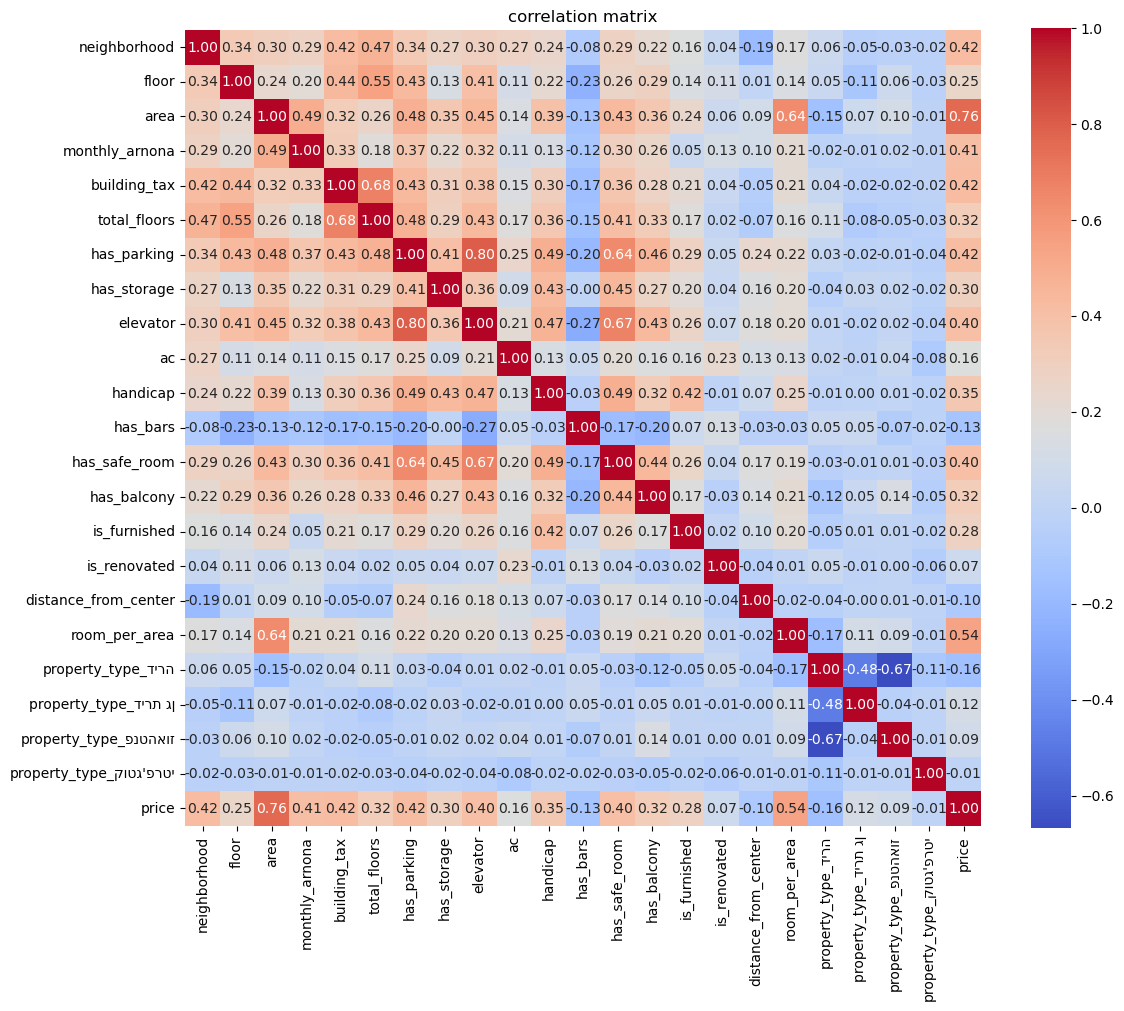

In [2172]:
df_numeric = df.select_dtypes(include=['number','category'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("correlation matrix")
plt.tight_layout()
plt.show()

#### This code evaluates the predictive power of each feature for the target price using PPS and visualizes the results in a bar chart to identify the most influential predictors.

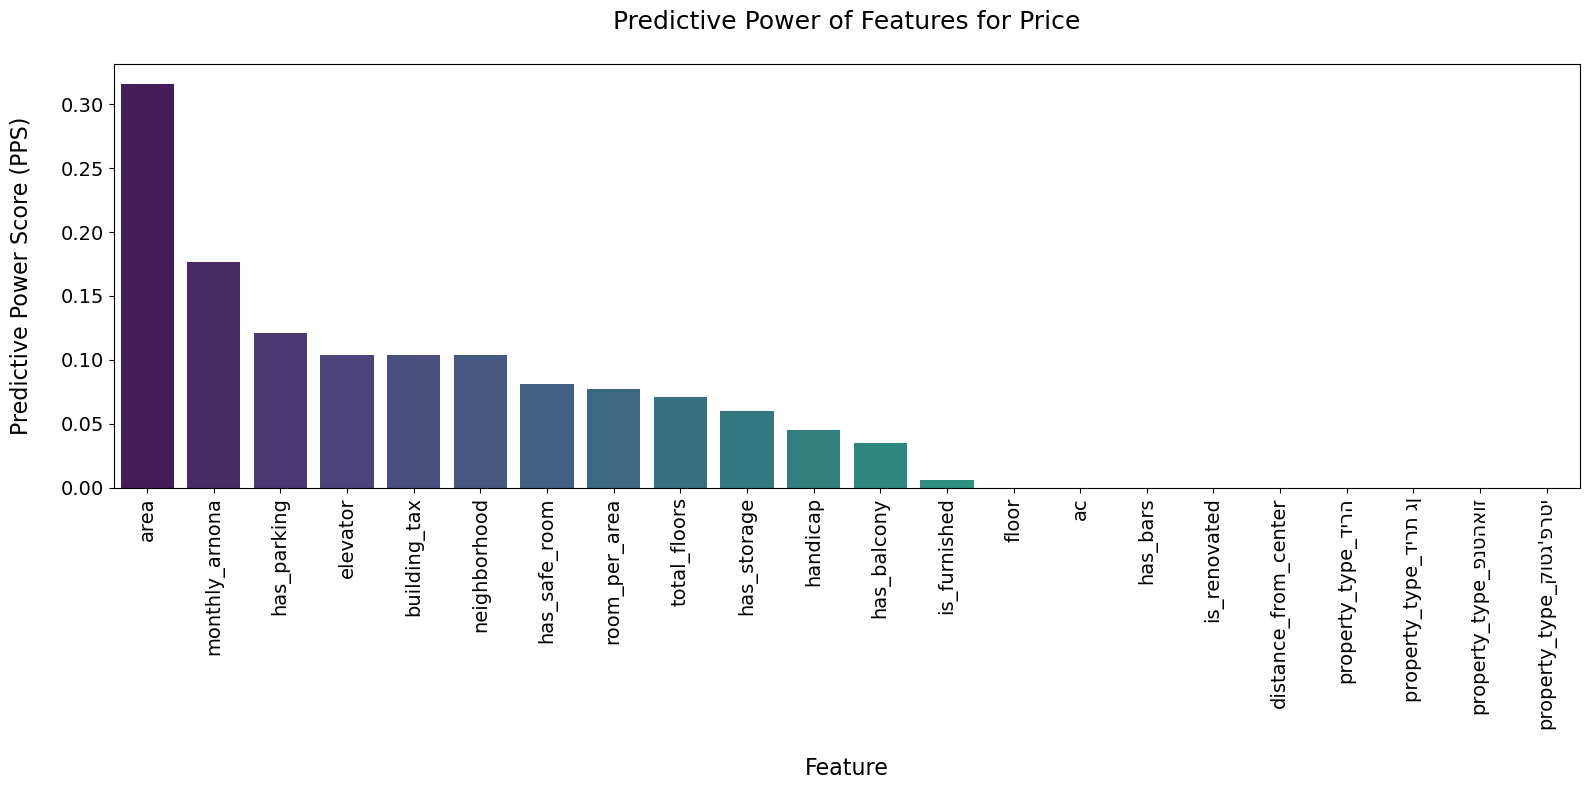

In [2173]:
pps_results = pps.predictors(df, "price")

pps_results_sorted = pps_results.sort_values(by='ppscore', ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(x='x', y='ppscore', data=pps_results_sorted, palette='viridis')

plt.xticks(rotation=90, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature', fontsize=16, labelpad=20)
plt.ylabel('Predictive Power Score (PPS)', fontsize=16, labelpad=20)
plt.title('Predictive Power of Features for Price', fontsize=18, pad=25)

plt.tight_layout()
plt.show()

In [2174]:
import warnings
warnings.filterwarnings('ignore')
df_pps = df.copy()
pps_matrix = pps.matrix(df_pps)
pps_price = pps_matrix[
    (pps_matrix['y'] == 'price') & 
    (pps_matrix['x'] != 'price')
].sort_values(by='ppscore', ascending=False)

top5_pps = pps_price.head(5)

print("The top 5 features with the highest PPS for price prediction:")
top5_pps[['x', 'ppscore']]

The top 5 features with the highest PPS for price prediction:


,x,ppscore
68,area,0.316073
91,monthly_arnona,0.176413
160,has_parking,0.121378
206,elevator,0.104074
114,building_tax,0.104020


## ElasticNet model

In [2198]:
model_ElasticNet = ElasticNet(max_iter=10000)
X_ElasticNet = df.drop(['price','ac'], axis=1)
y_ElasticNet = df['price']

param_grid_ElasticNet = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}

grid_search_ElasticNet = GridSearchCV(model, param_grid_ElasticNet, cv=10, scoring="neg_mean_squared_error")
grid_search_ElasticNet.fit(X_ElasticNet, y_ElasticNet)
y_pred_ElasticNet = grid_search_ElasticNet.predict(X_ElasticNet)
best_model_ElasticNet = grid_search_ElasticNet.best_estimator_
joblib.dump(best_model_ElasticNet, 'trained_model.pkl')
mse_ElasticNet = mean_squared_error(y_ElasticNet, y_pred_ElasticNet)
rmse_ElasticNet = np.sqrt(mse_ElasticNet)
r2_ElasticNet = r2_score(y_ElasticNet, y_pred_ElasticNet)
mae_ElasticNet = np.mean(np.abs(y_ElasticNet - y_pred_ElasticNet)) 

print("Best Params:", grid_search_ElasticNet.best_params_)
print(f"Mean Squared Error (MSE): {mse_ElasticNet:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ElasticNet:.4f}")
print(f"R-squared (R^2): {r2_ElasticNet:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ElasticNet:.4f}\n")
cv_scores_ElasticNet = cross_val_score(best_model_ElasticNet, X_ElasticNet, y_ElasticNet, cv=10, scoring='neg_mean_squared_error')
rmse_scores_ElasticNet = np.sqrt(-cv_scores_ElasticNet)
print(f"\n✅ Cross-Validation RMSE (10-fold): {rmse_scores_ElasticNet.mean():.2f} ± {rmse_scores_ElasticNet.std():.2f}")

coefficients = best_model_ElasticNet.coef_
feature_names = X_ElasticNet.columns
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients})

print("Feature Coefficients top 5:")
print(coef_df.sort_values(by="Coefficient", key=np.abs, ascending=False).head(5))

Best Params: {'alpha': 1.0, 'l1_ratio': 0.9}
Mean Squared Error (MSE): 8239851.7908
Root Mean Squared Error (RMSE): 2870.5142
R-squared (R^2): 0.6669
Mean Absolute Error (MAE): 1807.9776


✅ Cross-Validation RMSE (10-fold): 3113.28 ± 783.94
Feature Coefficients top 5:
                 Feature  Coefficient
2                   area  2380.786371
0           neighborhood   648.253744
15  distance_from_center  -634.951037
4           building_tax   633.454738
16         room_per_area   604.320898


<div dir="rtl">
<strong>חמשת המאפיינים בעלי ההשפעה הגדולה ביותר על המודל הם:</strong><br>
<code>area</code><br>
<code>room_per_area</code><br>
<code>neighborhood</code><br>
<code>distance_from_center</code> (שלילי)<br>
<code>building_tax</code>
</div>


## DecisionTree model

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

📊 Performance Metrics (on full training data):
R²: 0.7023
RMSE: 2714.04
MSE: 7366036.35
MAE: 1853.51

✅ Cross-Validation RMSE (10-fold): 3368.53 ± 837.54

Top 5 Most Important Features:
                 feature  importance
2                   area    0.808160
15  distance_from_center    0.073111
4           building_tax    0.061023
0           neighborhood    0.057706
12           has_balcony    0.000000


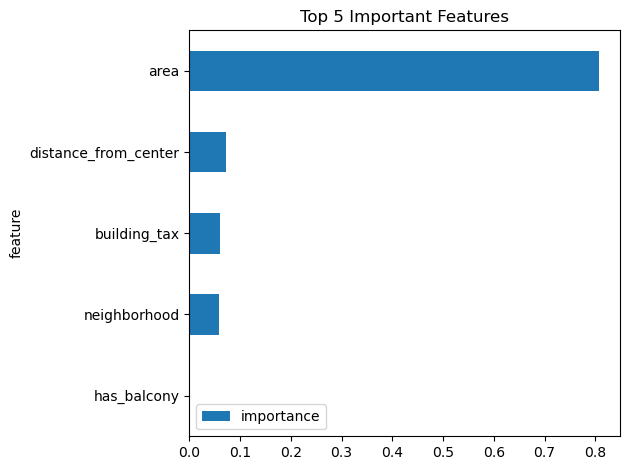

In [2199]:
model_DTR =  DecisionTreeRegressor(random_state=42)
X_DTR = df.drop(['price','ac'],axis=1)
y_DTR = df['price']
param_grid_DTR = {
    'max_depth': [3,5, 6, 7,10],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [2, 5,10]}

grid_search_DTR = GridSearchCV(
    estimator=model_DTR,
    param_grid=param_grid_DTR,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1)

grid_search_DTR.fit(X_DTR, y_DTR)
best_model_DTR = grid_search_DTR.best_estimator_

print("Best Parameters:", grid_search_DTR.best_params_)
y_pred_DTR = best_model_DTR.predict(X_DTR)
mse_DTR = mean_squared_error(y_DTR, y_pred_DTR)
rmse_DTR = np.sqrt(mse_DTR)
r2_DTR = r2_score(y_DTR, y_pred_DTR)
mae_DTR = mean_absolute_error(y_DTR, y_pred_DTR)

print(f"\n📊 Performance Metrics (on full training data):")
print(f"R²: {r2_DTR:.4f}")
print(f"RMSE: {rmse_DTR:.2f}")
print(f"MSE: {mse_DTR:.2f}")
print(f"MAE: {mae_DTR:.2f}")
cv_scores_DTR = cross_val_score(best_model_DTR, X_DTR, y_DTR, cv=10, scoring='neg_mean_squared_error')
rmse_scores_DTR = np.sqrt(-cv_scores_DTR)
print(f"\n✅ Cross-Validation RMSE (10-fold): {rmse_scores_DTR.mean():.2f} ± {rmse_scores_DTR.std():.2f}")

joblib.dump(best_model_DTR, 'decision_tree_model.pkl')

feature_names = X_DTR.columns 
importances = best_model_DTR.feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
top5 = importance_df.sort_values(by='importance', ascending=False).head(5)

print("\nTop 5 Most Important Features:")
print(top5)

top5.set_index('feature').plot(kind='barh', title='Top 5 Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<div dir="rtl">
<strong>חמשת המאפיינים בעלי ההשפעה הגדולה ביותר על המודל הם:</strong><br>
<code>area</code><br>
<code>distance_from_center</code><br>
<code>building_tax</code><br>
<code>neighborhood</code> <br>
<code>has_balcony </code>
</div>


<div dir="rtl">

<h3>🔍 בחירת שיטת Grid Search לאופטימיזציה</h3>
<h4>
בחרתי להשתמש בשיטת <strong>Grid Search</strong> לאופטימיזציה של ההיפר-פרמטרים, משום שטווח הערכים שנבדקו עבור כל פרמטר היה מצומצם יחסית.<br>
Grid Search מאפשר לבדוק את <strong>כל השילובים האפשריים</strong> בין הפרמטרים, ולכן מתאימה במיוחד למקרים שבהם מספר האפשרויות לא גדול מדי.<br><br>
</h4>
   <h4> 
שיטה זו עוזרת למצוא את <strong>השילוב האופטימלי</strong> של הפרמטרים בצורה מדויקת, מבלי להסתמך על בחירה אקראית, וכך משפרת את ביצועי המודל באופן יסודי ומבוסס.
   </h4> 
</div>


<h3 dir="rtl" style="text-align: right;">
✨ יצרתי 2 פונקציות שעוזרות לי להבין בכל מודל אילו פיצ'רים אני יכול להוריד כדי שהמודל יציג תוצאות של R<sup>2</sup> ו־RMSE יותר טובות
</h3>



In [1359]:
def evaluate_feature_removal_with_elasticnet(X, y, param_grid, cv=5):
    features = X.columns
    results = []

    base_model = ElasticNet(max_iter=10000)
    base_search = GridSearchCV(base_model, param_grid, cv=cv, scoring="neg_mean_squared_error")
    base_search.fit(X, y)
    best_base_model = base_search.best_estimator_
    
    y_pred = best_base_model.predict(X)
    baseline_r2 = r2_score(y, y_pred)
    baseline_rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"Baseline R²: {baseline_r2:.4f}")
    print(f"Baseline RMSE: {baseline_rmse:.2f}\n")

    for feature in features:
        X_reduced = X.drop(columns=[feature])

        model = ElasticNet(max_iter=10000)
        search = GridSearchCV(model, param_grid, cv=cv, scoring="neg_mean_squared_error")
        search.fit(X_reduced, y)
        best_model = search.best_estimator_

        y_pred_reduced = best_model.predict(X_reduced)
        r2 = r2_score(y, y_pred_reduced)
        rmse = np.sqrt(mean_squared_error(y, y_pred_reduced))

        results.append({
            'Feature Removed': feature,
            'Δ R²': r2 - baseline_r2,
            'Δ RMSE': rmse - baseline_rmse  
        })

    results_df = pd.DataFrame(results).sort_values(by='Δ R²', ascending=False)
    return results_df

In [2194]:
best_model = grid_search_ElasticNet.best_estimator_
results_df = evaluate_feature_removal_with_elasticnet(X_ElasticNet, y_ElasticNet, param_grid_ElasticNet, cv=10)

# הצגת טבלה
display(results_df)

Baseline R²: 0.6669
Baseline RMSE: 2870.51



,Feature Removed,Δ R²,Δ RMSE
3,monthly_arnona,0.000141,-0.606325
6,has_parking,0.000048,-0.208051
9,handicap,0.000001,-0.004859
20,property_type_קוטג'פרטי,-0.000008,0.036490
19,property_type_פנטהאוז,-0.000018,0.076699
12,has_balcony,-0.000046,0.200116
8,elevator,-0.000129,0.555830
1,floor,-0.000202,0.868409
17,property_type_דירה,-0.000303,1.305613
14,is_renovated,-0.000322,1.385451


In [1953]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

def evaluate_feature_removal_with_dtr(X, y, param_grid, cv=10):
    features = X.columns
    results = []

    # מודל בסיסי עם כל הפיצ'רים
    base_model = DecisionTreeRegressor()
    base_search = GridSearchCV(base_model, param_grid, cv=cv, scoring="neg_mean_squared_error")
    base_search.fit(X, y)
    best_base_model = base_search.best_estimator_

    y_pred = best_base_model.predict(X)
    baseline_r2 = r2_score(y, y_pred)
    baseline_rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"Baseline R²: {baseline_r2:.4f}")
    print(f"Baseline RMSE: {baseline_rmse:.2f}\n")

    # עבור כל פיצ'ר — בודק השפעה על המודל
    for feature in features:
        X_reduced = X.drop(columns=[feature])

        model = DecisionTreeRegressor()
        search = GridSearchCV(model, param_grid, cv=cv, scoring="neg_mean_squared_error")
        search.fit(X_reduced, y)
        best_model = search.best_estimator_

        y_pred_reduced = best_model.predict(X_reduced)
        r2 = r2_score(y, y_pred_reduced)
        rmse = np.sqrt(mean_squared_error(y, y_pred_reduced))

        results.append({
            'Feature Removed': feature,
            'Δ R²': r2 - baseline_r2,
            'Δ RMSE': rmse - baseline_rmse
        })

    results_df = pd.DataFrame(results).sort_values(by='Δ R²', ascending=False)
    return results_df


In [2195]:
results_df = evaluate_feature_removal_with_dtr(X_DTR, y_DTR, param_grid_DTR, cv=10)
display(results_df)

Baseline R²: 0.7023
Baseline RMSE: 2714.04



,Feature Removed,Δ R²,Δ RMSE
16,room_per_area,0.093219,-464.655442
10,has_bars,0.000000,0.000000
1,floor,0.000000,0.000000
19,property_type_פנטהאוז,0.000000,0.000000
18,property_type_דירת גן,0.000000,0.000000
17,property_type_דירה,0.000000,0.000000
14,is_renovated,0.000000,0.000000
13,is_furnished,0.000000,0.000000
12,has_balcony,0.000000,0.000000
11,has_safe_room,0.000000,0.000000


<div dir="rtl" align="right">

<h3>🔍 שיפור ביצועי המודל באמצעות הסרת עמודות לא מועילות</h3>

<h4>
ניתן לשפר את ביצועי המודלים על ידי הסרה של עמודות שבעת הסרתן מתקבל:
</h4>

<ul>
  <li>ירידה בערך ה־<b>RMSE</b> (כלומר שגיאה קטנה יותר).</li>
  <li>ועלייה בערך ה־<b>R²</b> (כלומר המודל מסביר טוב יותר את השונות בנתונים).</li>
</ul>

<h4>
לדוגמה, הסרת העמודה <code>ac</code> הניבה את השינויים הבאים:
</h4>

<ul>
  <li>✅ ירידה של <b>75</b> בערך ה־RMSE.</li>
  <li>✅ עלייה קלה בערך ה־R².</li>
</ul>

<h4>🛠️ לכן, בחרתי להסיר את העמודה הזו משני המודלים.</h4>

</div>


<div dir="rtl">

### 🔍 השוואה בין המודלים: Elastic Net מול עץ החלטה

| מדד/מאפיין                    | Elastic Net                | עץ החלטה                  |
|------------------------------|----------------------------|---------------------------|
| **R²**                        | 0.6669                     | 0.7023                    |
| **RMSE**                      | 2870.51                    | 2714.04                   |
| **MAE**                       | 1807.98                    | 1853.51                   |
| **Cross-Validation RMSE**     | 3113.28 ± 783.94           | 3368.53 ± 837.54          |

### 🧠 המאפיינים החשובים ביותר בכל מודל:

| דירוג | Elastic Net             | עץ החלטה                 |
|-------|--------------------------|---------------------------|
| 1     | area                     | area                      |
| 2     | neighborhood             | distance_from_center      |
| 3     | distance_from_center     | building_tax              |
| 4     | building_tax             | neighborhood              |
| 5     | room_per_area            | has_balcony               |

</div>


<div dir="rtl">

### 🧩 הסבר על ההבדלים או הדמיון בין המודלים
<h4>
ניתן לראות שההבדלים בין המודלים אינם דרמטיים, אך קיימים:
    </h4>
    
- מודל **עץ החלטה** מציג תוצאה מעט טובה יותר במדד R² (0.702 לעומת 0.666) ו-RMSE נמוך יותר, כלומר הוא מתאים טוב יותר לנתונים שבידינו.
- עם זאת, מודל **Elastic Net** מציג תוצאה יציבה יותר ב-Cross-Validation (סטיית תקן נמוכה יותר), מה שמרמז שהוא כללי יותר ועלול להציג ביצועים טובים יותר על דאטה חדש.

### 🔍 הסבר אפשרי להבדלים:

- מודל **Elastic Net** הוא מודל ליניארי ולכן הוא מניח קשרים ליניאריים בין הפיצ'רים למחיר. הוא רגיש לערכים קיצוניים ומספק תובנות פרשניות על כיווני ההשפעה (חיובי או שלילי).
- מודל **עץ החלטה** גמיש יותר ויודע לטפל בקשרים לא ליניאריים ובאינטראקציות מורכבות בין משתנים, מה שעשוי להסביר את הביצועים הטובים יותר שלו, אך הוא גם נוטה יותר לאוברפיטינג – כפי שניתן לראות מהסטייה הגבוהה ב-CV.

-לסיכום, שני המודלים מציגים תוצאות טובות, אך יש עדיפות לעץ החלטה בביצועים בפועל, ולעומת זאת ל -Elastic Net ביציבות ובהבנה פרשנית של המודל.

</div>


<div dir="rtl" align="right">

## הרצת הדאטה טסט

</div>

In [ ]:
en_model = joblib.load("trained_model.pkl")
test_df = pd.read_csv('test.csv')

features = test_df.drop(columns=['price'])
res = test_df['price']

# Prepare the features dataframe
features_prepared = preper_data(features, "test")

# Make predictions
preds = en_model.predict(features_prepared)

# Compare RMSE between res and the predictions
rmse = np.sqrt(np.mean((res - preds) ** 2))
print("RMSE for ID", id, "is", rmse)